In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

import RadarEnv_ddpg_n as env
print(env.pos)

is_softmax=0 #先申明，训练时使用
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


[-7500.0, -2500.0, 2500.0, 7500.0]


c:\Users\10521\.conda\envs\essay\lib\site-packages\gym\spaces\box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        #self.action_dim=action_dim
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        #多加2层试试看
        self.fc2 = torch.nn.Linear(hidden_dim, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        #尝试构建一个多头输出
        total_dim=env.env_radar_num*env.jammer_mode_num
        self.out1=torch.nn.Linear(32,total_dim )#输出离散值组合
        self.out2=torch.nn.Linear(32, 1)#输出连续功率P
        #self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, state):
        #actor的前向右两种工作模式：1 输入一个单独的state进行预测action 2输入一个batch的state进行目标更新
        
       
            x = F.relu(self.fc1(state))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            
            logits=self.out1(x) #输出离散组合logits

            if is_softmax==0:
                out=logits
            elif is_softmax==1:
                out=torch.softmax(logits,dim=-1) #离散动作 对最后一个维度进行softmax 单输入0 多输入dim1
            else:
                out=env.gumbel_softmax(logits,temperature=2.0,eps=epsilon)#此时输出的是一个onehot值
            

            o1=out.detach().argmax(dim=-1)
            #o1=torch.argmax(out,dim=-1)
            o2=torch.tanh(self.out2(x)) #连续P

            index=(o1 % env.env_radar_num).detach().cpu()
            mode=((o1//env.env_radar_num)).detach().cpu()
            P=((o2+1)/2)*(env.span[1])+env.low[1]#标量/矢量运算
            P=P.detach().cpu().T[0]

            if len(list(state.shape))==1:#单输入
                action=np.array((index,P,mode))
            else:#batch输入
                action=np.array([np.array((x,y,z)) for x,y,z in zip(index,P,mode)])
                
            return torch.tensor(action,dtype=torch.float32)
    
      #这里取整是没有用的，整个tensor的类型需要统一 要后续用到index的时候再取整
        
        #action=torch.cat([index,P,mode],dim=0)#tensor拼接
        #action=np.ndarray([index,P,mode],dtype=np.float32)
        #action=torch.tensor([index,int(P),mode]).view(-1,3)#tensor拼接
        #action=torch.tensor(action)

        
    #注意网络维度问题
    '''y = F.relu(self.fc1(x))
        #tanh [-1,1]
        result=torch.tanh(self.fc2(y))
        ones=torch.tensor([1]*result.shape[0],device=device)
        #归一到0-1
        return (result+ones)/(2*ones) #* self.action_bound'''
    

        
    '''def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.softmax(self.fc2(x),dim=) * self.action_bound
        #使用softmax归一到0-1'''


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 64)
        self.fc3 = torch.nn.Linear(64, 32) 
        self.fc_out = torch.nn.Linear(32, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a.to(device)], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc_out(x)

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device,epsilon):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device
        self.epsilon=epsilon
        
    def take_action(self, state,explore=True):#takeaction只有一个调用点，可以探索
        #state转换为tensor,state是有离散的
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        #使用actor网络输出action，-1-1 actor是policynet的一个实例
        action = self.actor.forward(state)
        
        if explore:
            #离散量引入随机探索epsilon-greedy
            if np.random.random() < self.epsilon:#随机
                action =  torch.tensor(np.array([np.random.randint(env.env_radar_num),action[1],np.random.randint(env.jammer_mode_num)]),device=device)
            #连续动作加噪声
            action[1] = action[1] + self.sigma*env.span[1] * torch.tensor(np.random.randn(1),device=device)
        
        #功率范围限制
        if action[1]<env.low[1]:
            action[1]=env.low[1]
        elif action[1]>env.hi[1]:
            action[1]=env.hi[1]
        
        return action #输出一个tensor
        
        # 给动作添加噪声，增加探索
        #action = action + self.sigma * torch.tensor(np.random.randn(self.action_dim),device=device)
        #这样导致tensor会超过1，取mod
        #return torch.remainder(action+1,2)-1#怀疑这里可能丢信息

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        #按照batch更新网络
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 3).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        target_actions = self.target_actor(next_states)
        next_q_values = self.target_critic(next_states, target_actions)
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [4]:
energy_ratio=[]#评价指标：能量占比
strike_range=[]
action_record=[]

def train_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                
                #每一轮都初始化dict
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                #reset env
                radar_list,jetplane=env.Env_init()
                state=env.get_current_state(radar_list,jetplane)#初始状态

                done = False
                while not done:
                    action = agent.take_action(state)
                    #更新核心
                    next_state, reward, done = env.step(radar_list,jetplane,action)
                    #core stage

                    action_array=action.detach().cpu().numpy()
                    #action_array=action
                    #reward=np.array(reward.cpu())


                    replay_buffer.add(state, action_array, reward, next_state, done)
                    state = next_state
                    episode_return += reward.detach().cpu()
                    if replay_buffer.size() > minimal_size:#如果比min小，则丢弃
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)

                if (i_episode + 1) % 1 == 0:#10
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'reward':
                        '%.3f' % np.mean(return_list[-10:]),
                        'strike_range':
                        '%.0f' % (np.mean(strike_range[-10:])/1E3),
                        'energy_ratio':
                        '%.3f' % np.mean(energy_ratio[-10:])
                    })
                pbar.update(1)
                for i in range(len(radar_list)):
                    
                    radar_list[i].__del__() #记得销毁
                energy_ratio.append(jetplane.calc_energy_ratio())

                strike_range.append(jetplane.get_position()[0])
                action_record=jetplane.get_action_record()
                del jetplane
    return return_list

In [5]:
#超参数
actor_lr = 3e-5 #4
critic_lr = 3e-4 #3
#
num_episodes = 50
#
hidden_dim = 256
hidden_dim1=64
gamma = 0.98
tau = 0.001  #0.005 软更新参数,w'=tau w +(1-tau) w
buffer_size = 3000#1000
minimal_size = 150#200
batch_size = 128#64从buffer中采样数据进行训练

sigma = 0.01  # 高斯噪声标准差,用于P探索(0,1)0.01
epsilon=0.30 #eps-greedy探索

is_softmax=2 #0logits 1softmax 2gunbel-softmax


env_name = 'Radar_env'
#env = gym.make(env_name)
radar_list,jetplane=env.Env_init()

#初始化随机
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observe_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = [1,1,1]#[3,env.Pmax,4]#知不知道tensor能不能对应相乘 1# env.action_space.high[0]  # 动作最大值 #全部归一到0-1
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device,epsilon)

return_list = train_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\10521\AppData\Local\Temp\ipykernel_21604\3881536483.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  P=P.detach().cpu().T[0]
C:\Users\10521\AppData\Local\Temp\ipykernel_21604\3518558632.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 3).to(self.device)
c:\Users

c:\Users\10521\.conda\envs\essay\lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


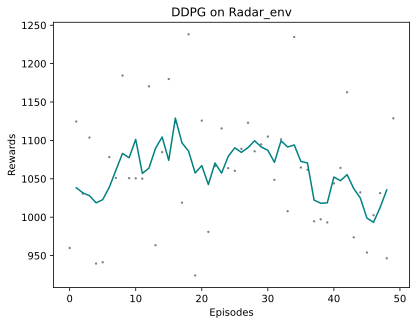

In [6]:
#绘图部分
%matplotlib inline
%config InlineBackend.figure_format='svg'      # 设置为矢量图格式

episodes_list = list(range(len(return_list)))
#开始数据分析
plt.scatter(episodes_list, return_list,c='gray',s=2)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DDPG on {}'.format(env_name))
#plt.ylim(1200, max(return_list)+10)

mean_return=[]
mean_interval=5#最近15步取平均 窗口大小必须奇数

mean_return=rl_utils.moving_average(return_list, mean_interval)
'''for i in range(0,len(return_list),mean_interval):
    mean_return.append(np.mean(return_list[i:i+mean_interval]))
'''
plt.plot(episodes_list[1:-1:1], mean_return[1:-1:1],c='teal')
#plt.plot(episodes_list, mean_return)
plt.show()


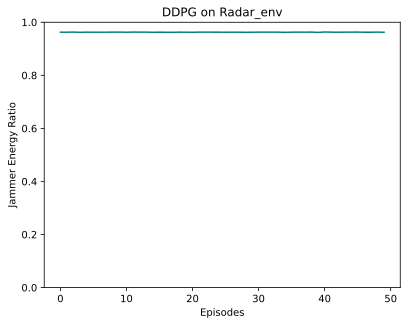

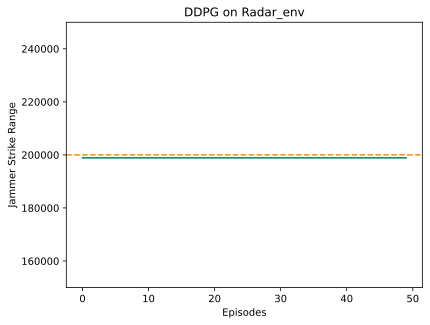

In [7]:
#评价指标
plt.ylim(0,1)
plt.plot(episodes_list, energy_ratio,c='teal')
plt.xlabel('Episodes')
plt.ylabel('Jammer Energy Ratio')



mean_ratio=[]
mean_interval=5#最近5步取平均
'''for i in range(0,len(energy_ratio),mean_interval):
    mean_ratio.append(np.mean(energy_ratio[i:i+mean_interval]))

plt.scatter(episodes_list[::mean_interval], mean_ratio,c='red')'''

mean_interval=3#最近15步取平均 窗口大小必须奇数
mean_ratio=rl_utils.moving_average(energy_ratio, mean_interval)
#plt.plot(episodes_list, mean_ratio,c='red')

plt.title('DDPG on {}'.format(env_name))
plt.show()


#plt.ylim(0, max(strike_range)+2000)
plt.plot(episodes_list, strike_range,c='teal',ls='-')
plt.xlabel('Episodes')
plt.ylabel('Jammer Strike Range')
plt.ylim(150E3,250E3)

mean_strike=[]
mean_interval=3#最近十步取平均
mean_strike=rl_utils.moving_average(strike_range, mean_interval)
'''for i in range(0,len(strike_range),mean_interval):
    mean_strike.append(np.mean(strike_range[i:i+mean_interval]))
'''
#plt.plot(episodes_list[::mean_interval], mean_strike)
#plt.plot(episodes_list, mean_strike,c='red')

#plt.axhline(250E3, c='orange', ls='--')
plt.axhline(200E3, c='darkorange', ls='--')
#plt.axhline(451E3, c='orangered', ls='--')
plt.title('DDPG on {}'.format(env_name))
plt.show()

In [8]:
#重演最后一步,开启新的一轮
radar_list,jetplane=env.Env_init()
state=env.get_current_state(radar_list,jetplane)#初始状态
done = False
episode_return=0

radar_list,jetplane=env.Env_init()
state=env.get_current_state(radar_list,jetplane)#初始状态

done = False
while not done:
    action = agent.take_action(state,explore=False)
#更新核心
    next_state, reward, done = env.step(radar_list,jetplane,action)
    #core stage

    action_array=action.detach().cpu().numpy()
    #action_array=action
    #reward=np.array(reward.cpu())


    replay_buffer.add(state, action_array, reward, next_state, done)
    state = next_state
    episode_return += reward.detach().cpu()




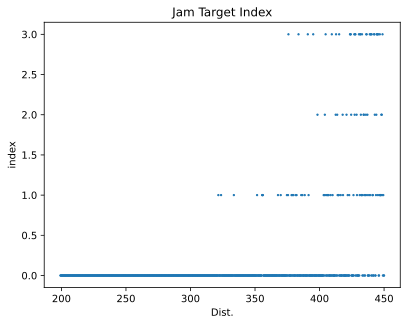

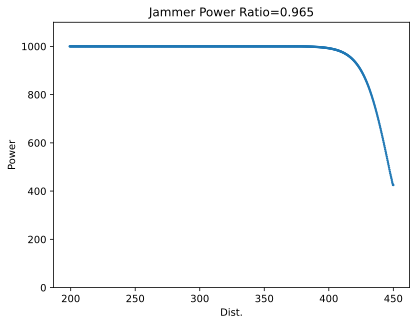

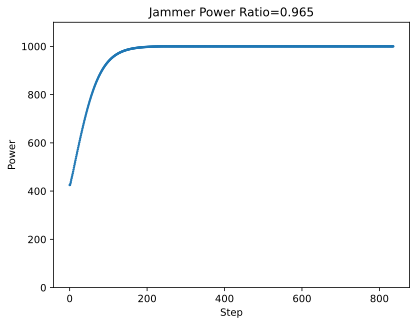

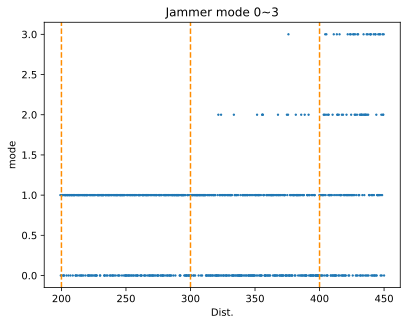

In [9]:

action_record=(jetplane.get_action_record())

index_list=[sample[0] for sample in action_record]
P_list=[action[1] for action in action_record]
mode_list=[action[2] for action in action_record]

dist=450-0.3*np.array(range(0,len(mode_list)))


plt.title('Jam Target Index')
plt.ylabel('index')
plt.xlabel('Dist.')
plt.scatter(dist, index_list,s=2)
plt.show()

plt.title('Jammer Power Ratio={:.3f}'.format(((sum(P_list)/len(P_list))/env.Pmax)))
plt.ylabel('Power')
plt.xlabel('Dist.')
plt.ylim(0,1100)
plt.scatter(dist, P_list,s=2)
plt.show()

plt.title('Jammer Power Ratio={:.3f}'.format(((sum(P_list)/len(P_list))/env.Pmax)))
plt.ylabel('Power')
plt.xlabel('Step')
plt.ylim(0,1100)
plt.scatter(range(P_list.__len__()), P_list,s=2)
plt.show()


plt.title('Jammer mode 0~3')
plt.ylabel('mode')
plt.xlabel('Dist.')
plt.scatter(dist, mode_list,s=2)

plt.axvline(400, c='darkorange', ls='--')
plt.axvline(300, c='darkorange', ls='--')
plt.axvline(200, c='darkorange', ls='--')

plt.show()



In [10]:
action_record

[tensor([  0.0000, 425.0310,   0.0000]),
 tensor([  0.0000, 425.5297,   3.0000]),
 tensor([  1.0000, 431.4377,   2.0000]),
 tensor([  0.0000, 437.8367,   2.0000]),
 tensor([  3.0000, 445.8972,   3.0000]),
 tensor([  1.0000, 453.2762,   1.0000]),
 tensor([  2.0000, 459.6348,   0.0000]),
 tensor([  2.0000, 466.7256,   2.0000]),
 tensor([  1.0000, 473.8680,   1.0000]),
 tensor([  1.0000, 481.0923,   0.0000]),
 tensor([  1.0000, 488.8045,   3.0000]),
 tensor([  3.0000, 496.9426,   1.0000]),
 tensor([  1.0000, 504.6882,   3.0000]),
 tensor([  0.0000, 512.3900,   1.0000]),
 tensor([  0.0000, 520.0884,   1.0000]),
 tensor([  3.0000, 527.7042,   3.0000]),
 tensor([  1.0000, 535.2493,   1.0000]),
 tensor([  3.0000, 542.7805,   1.0000]),
 tensor([  3.0000, 550.2944,   1.0000]),
 tensor([  3.0000, 557.7877,   0.0000]),
 tensor([  2.0000, 565.2568,   2.0000]),
 tensor([  1.0000, 572.6985,   0.0000]),
 tensor([  0.0000, 580.1094,   3.0000]),
 tensor([  0.0000, 587.4864,   3.0000]),
 tensor([  2.000

In [11]:
##我想解一个至少需要的P的方程##

import sympy
r,p = sympy.symbols("r,p")

s = sympy.solve(((9.718E12*r**2)/p)**0.25-r, p)
print(s)
env.pos

[9718000000000.09/r**2]


[-7500.0, -2500.0, 2500.0, 7500.0]

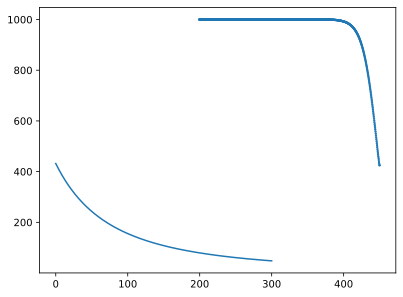

In [12]:
##我想解一个至少需要的P的方程##

def solution(r):
    return 9718000000000.09/r**2

rx=np.linspace(450e3,150e3,1000)
step=(450e3-rx)*1e-3
plt.plot(step,solution(rx)[::-1])

plt.scatter(dist, P_list,s=2)

plt.show()